Continuation of Periodic Orbits in the CR3BP
=====================================

In this example, we will show how it is possible to use heyoka.py's [expression system](<./The expression system.ipynb>), to compute the state transition matrix of the [circular restricted three-body problem](<./The restricted three-body problem.ipynb>) via [variational equations](<./The variational equations.ipynb>) and outline its use to find periodic orbits via a simple continuation scheme.

**NOTE**: There is quite some literature on finding periodic orbits in the CR3BP, a plethora of very clever techniques have been developed in the past. This notebook implements only a basic approach as it only aims to show the use of heyoka in this field.

We make some standard imports:

In [1]:
import heyoka as hy
import numpy as np
import time

from scipy.optimize import root_scalar

from matplotlib.pylab import plt

... and define some functions that will help later on to visualize our trajectories and make nice plots. (ignore them and come back to this later in case you are curious)

In [2]:
def potential_function(position,mu):
    """Computes the system potential
        Args:
            position (array-like): The position in Cartesian coordinates
            mu (float): The value of the mu parameter.

        Returns:
            The potential
    """
    x,y,z=position
    r_1=np.sqrt((x-mu)**2+y**2+z**2)
    r_2=np.sqrt((x-mu+1)**2+y**2+z**2)
    Omega=1./2.*(x**2+y**2)+(1-mu)/r_1+mu/r_2
    return Omega

def jacobi_constant(state,mu):
    """Computes the system Jacobi constant
        Args:
            state (array-like): The system state (x,y,z,px,py,pz)
            mu (float): The value of the mu parameter.

        Returns:
            The Jacobi constant for the state
    """
    x,y,z,px,py,pz=state
    vx = px + y
    vy = py - x
    vz = pz
    r_1=np.sqrt((x-mu)**2+y**2+z**2)
    r_2=np.sqrt((x-mu+1)**2+y**2+z**2)
    Omega=1/2*(x**2+y**2)+(1-mu)/r_1+mu/r_2
    T=1/2*(vx**2+vy**2+vz**2)
    C=Omega-T
    return C

## The Circular Restricted 3 Body Problem dynamics

Let us start defining the equations of motion for the Circular Restricted 3 Body Problem (CR3BP from now on). 

The problem is usually formulated in a rotating reference frame in which the two massive bodies are at rest. In the rotating reference frame, the equations of motion for the massless particle's cartesian coordinates $\left(x, y, z\right)$ and conjugated momenta $\left(p_x, p_y, p_z\right)$ read:

$$
\begin{aligned}
\dot{x} & = p_x+y,\\
\dot{y} & = p_y-x, \\
\dot{z} & = p_z, \\
\dot{p}_x & = p_y - \frac{1-\mu}{r_{PS}^3}\left( x - \mu \right)-\frac{\mu}{r_{PJ}^3}\left( x - \mu + 1\right), \\
\dot{p}_y & = -p_x-\left( \frac{1-\mu}{r_{PS}^3} +  \frac{\mu}{r_{PJ}^3}\right)y, \\
\dot{p}_z & = -\left( \frac{1-\mu}{r_{PS}^3} +  \frac{\mu}{r_{PJ}^3}\right)z,
\end{aligned}
$$

where $\mu$ is a mass parameter, $r_{PS}^2=\left( x-\mu \right)^2+y^2+z^2$ and $r_{PJ}^2=\left( x -\mu + 1 \right)^2+y^2+z^2$. 

NOTE: In these equations it is assumed that $M_1 + M_2 = 1$ and the Cavendish constant $G=1$. The biggest mass is then indicated with $1-\mu$, while the smallest with $\mu$. The biggest mass is placed in $x = \mu$ and the smallest in $x = \mu-1$ so that the distance between primaries is also 1. All remaining units are induced by these choices.

We also refer to the whole state with the symbol $\mathbf x = [x,y,z,p_x, p_y, p_z]$ and the right hand side of the dynamic equations with the symbol $\mathbf f$ so that $\dot{\mathbf x} = \mathbf f(\mathbf x)$. In general we use bold for vectors matrices and normal fonts for their components, hence $\mathbf M$ will, as an example, have components $M_{ij}$.

With respect to the heyoka.py notebook on [circular restricted three-body problem](<./The restricted three-body problem.ipynb>), we will be here making use of numpy arrays of heyoka expressions as to simplify the notation later on when we need to compute the variational equations.

In [3]:
# Create the symbolic variables.
symbols_state = ["x", "y", "z", "px", "py", "pz"]
x = np.array(hy.make_vars(*symbols_state))
# This will contain the r.h.s. of the equations
f = []

rps_32 = ((x[0] - hy.par[0])**2 + x[1]**2 + x[2]**2)**(-3/2.)
rpj_32 = ((x[0] - hy.par[0]  + 1.)**2 + x[1]**2 + x[2]**2)**(-3/2.)

# The equations of motion.
f.append(x[3] + x[1])
f.append(x[4] - x[0])
f.append(x[5])
f.append(x[4] - (1. - hy.par[0]) * rps_32 * (x[0] - hy.par[0]) - hy.par[0] * rpj_32 * (x[0] - hy.par[0] + 1.))
f.append(-x[3] -((1. - hy.par[0]) * rps_32 + hy.par[0] * rpj_32) * x[1])
f.append(-((1. - hy.par[0]) * rps_32 + hy.par[0] * rpj_32) * x[2])
f = np.array(f)

Let us also define a function to compute the position of the Lagrangian points:

In [4]:
# Introduce a compiled function for the evaluation
# of the dynamics equation for px.
px_dyn_cf = hy.cfunc([f[3]], vars=x)

def compute_L_points(mu):
    """Computes The exact position of the Lagrangian points. To do so it finds the zeros of the
    the dynamics equation for px.
    
        Args:
            mu (float): The value of the mu parameter.

        Returns:
            xL1, xL2, xL3, xL45, yL45: The coordinates of the various Lagrangian Points
    """
    # Position of the lagrangian points approximated
    xL1 = (mu-1) + (mu/3/(1-mu))**(1/3)
    xL2 = (mu-1) - (mu/3/(1-mu))**(1/3)
    xL3 = -(mu-1) - 7/12 * mu / (1-mu)
    yL45 = np.sin(60/180*np.pi)
    xL45 = -0.5 + mu

    # Solve for the static equilibrium from the approximated solution
    def equilibrium(expr, x,y):
        return px_dyn_cf([x, y, 0., -y, x, 0.], pars=[mu])[0]
    xL1 = root_scalar(lambda x: equilibrium(f, x,0.), x0=xL1,x1=xL1-1e-2).root
    xL2 = root_scalar(lambda x: equilibrium(f, x,0.), x0=xL2,x1=xL2-1e-2).root
    xL3 = root_scalar(lambda x: equilibrium(f, x,0.), x0=xL3,x1=xL3-1e-2).root;
    return xL1, xL2, xL3, xL45, yL45

## The variational equations

We now compute the variational equations expressing the state transition matrix defined as $\delta \mathbf x(t) = \mathbf \Phi(t)\delta \mathbf x(0)$. We define its $ij$ component as:

$$
\Phi_{ij}(t) = \frac{d x_i(t)}{dx_j(0)}
$$

hence the variational equations:

$$
\frac{d }{dt} \Phi_{ij}(t) = \frac{d}{dt}\left(\frac{d x_i(t)}{dx_j(0)}\right) = \frac{d}{dx_j(0)}\left(\frac{d x_i(t)}{dt}\right) = \frac{d f_i(x(t))}{dx_j(0)}
$$

expanding the total derivative in the last term we get:

$$
\frac{d}{dt}\Phi_{ij}(t) = \sum_k \frac{\partial f_i}{\partial x_k}\frac{dx_k(t)}{dx_j(0)}=\sum_k \frac{\partial f_i}{\partial x_k} \Phi_{kj}(t)
$$

which can be written in compact matrix form as:

$$
\frac{d}{dt}\mathbf \Phi(t) = \left[\frac{\partial f_i}{\partial x_k}\right] \mathbf \Phi(t)
$$

Note that the initial conditions are, trivially: $\mathbf \Phi(0) = \mathbf I$

Let us then introduce these variational equations using heyoka.

First, we define the various symbols for the components of the state transition matrix

In [5]:
symbols_phi = []
for i in range(6):
    for j in range(6):
        # Here we define the symbol for the variations
        symbols_phi.append("phi_"+str(i)+str(j))  
phi = np.array(hy.make_vars(*symbols_phi)).reshape((6,6))

Then we find the various $\left[\frac{\partial f_i}{\partial x_k}\right]$:

In [6]:
dfdx = []
for i in range(6):
    for j in range(6):
        dfdx.append(hy.diff(f[i],x[j]))
dfdx = np.array(dfdx).reshape((6,6))

... and finally the r.h.s. of the variational equations is:

In [7]:
# The (variational) equations of motion
dphidt = dfdx@phi

how very very beautiful!

**NOTE**: The variational equations are here written for a chaotic system, thus for long interation times the variations can explode and have a negative influence for the step size control. Nothing we can do about it, it's chaos! 

## Putting all together and integrating some initial conditions
Let us put all the equations 6 + 6x6 = 42 into one big Taylor integrator and perform one numerical integration.

First, we create the dynamics ...

In [8]:
dyn = []
for state, rhs in zip(x,f):
    dyn.append((state, rhs))
for state, rhs in zip(phi.reshape((36,)),dphidt.reshape((36,))):
    dyn.append((state, rhs))
# These are the initial conditions on the variational equations (the identity matrix)
ic_var = np.eye(6).reshape((36,)).tolist()

... then we instantiate the Taylor integrator (high accuracy and no compact mode)

In [9]:
start_time = time.time()
ta = hy.taylor_adaptive(
    # The ODEs.
    dyn,
    # The initial conditions.
    [-0.45, 0.80, 0.00, -0.80, -0.45, 0.58] + ic_var,
    # Operate below machine precision
    # and in high-accuracy mode.
    tol = 1e-18, high_accuracy = True
)
print("--- %s seconds --- to build the Taylor integrator" % (time.time() - start_time))

--- 4.743351936340332 seconds --- to build the Taylor integrator


... and we perform and time a numerical propagation for these conditions

In [10]:
ic = [-0.80, 0.0, 0, 0.0, -0.6276410653920693, 0.]
t_final=200
mu=0.01
ta.pars[0] = mu
# Reset the state
ta.time = 0
ta.state[:] = ic + ic_var
# Time grid
t_grid = np.linspace(0, t_final, 2000)

In [11]:
# Go ...
start_time = time.time()
out = ta.propagate_grid(t_grid)
print("--- %s seconds --- to propagate" % (time.time() - start_time))

--- 0.051287174224853516 seconds --- to propagate


To check and validate, let's plot the trajectory and some cosmetics to visualize the solution

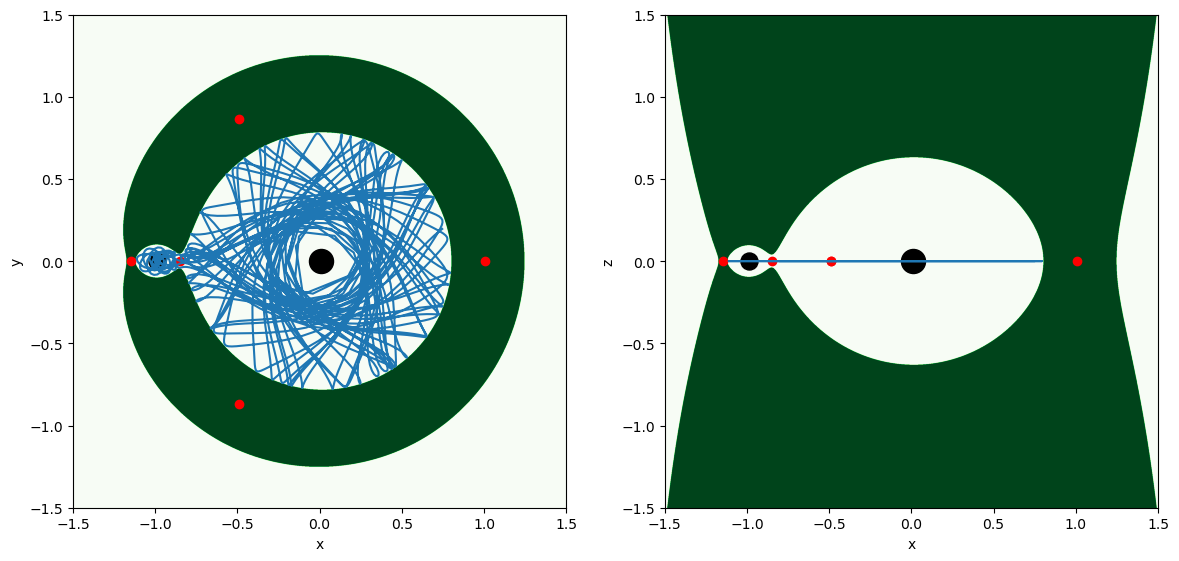

In [12]:
plt.figure(figsize=(14,14))

# Lets find the postiion of the lagrangian points
xL1, xL2, xL3, xL45, yL45 = compute_L_points(mu)
# We also compute the Jacobi constant
C_jacobi = jacobi_constant(ic, mu)

# Plot the trajectory (xy)
plt.subplot(1,2,1)
plt.plot(out[5][:, 0], out[5][:, 1])
plt.xlabel("x")
plt.ylabel("y")
# Plot the zero velocity curve
xx = np.linspace(-1.5,1.5,2000)
yy = np.linspace(-1.5,1.5,2000)
x_grid,y_grid = np.meshgrid(xx,yy)
im = plt.imshow( ((potential_function((x_grid,y_grid,np.zeros(np.shape(x_grid))),mu=mu)<=C_jacobi)).astype(int) , 
                extent=(x_grid.min(),x_grid.max(),y_grid.min(),y_grid.max()),origin="lower", cmap="Greens")
# Plot the lagrangian points and primaries
plt.scatter(mu, 0, c='k', s=300)
plt.scatter(mu-1, 0, c='k', s=150)
plt.scatter(xL1, 0, c='r')
plt.scatter(xL2, 0, c='r')
plt.scatter(xL3, 0, c='r')
plt.scatter(-0.5+mu, yL45, c='r')
plt.scatter(-0.5+mu, -yL45, c='r')

# Plot the trajectory (xz)
plt.subplot(1,2,2)
plt.plot(out[5][:, 0], out[5][:, 2])
plt.xlabel("x")
plt.ylabel("z");
# Plot the zero velocity curve
xx = np.linspace(-1.5,1.5,2000)
zz = np.linspace(-1.5,1.5,2000)
x_grid,z_grid = np.meshgrid(xx,zz)
im = plt.imshow( ((potential_function((x_grid,np.zeros(np.shape(x_grid)), z_grid),mu=mu)<=C_jacobi)).astype(int) , 
                extent=(x_grid.min(),x_grid.max(),z_grid.min(),z_grid.max()),origin="lower", cmap="Greens")
# Plot the lagrangian points and primaries
plt.scatter(mu, 0, c='k', s=300)
plt.scatter(mu-1, 0, c='k', s=150)
plt.scatter(xL1, 0, c='r')
plt.scatter(xL2, 0, c='r')
plt.scatter(xL3, 0, c='r')
plt.scatter(-0.5+mu, 0, c='r')
plt.scatter(-0.5+mu, 0, c='r')

All fine ..... at least visually! So far we have not made use of the variational equations at all, but this is about to change!

## Finding Periodic Orbits
To find a periodic orbit in a dynamical system, a first step to then possibly find a whole family of them, we will proceed as follows:

* Get some *decent* initial conditions, for example one can use the [Poincaré–Lindstedt method](https://en.wikipedia.org/wiki/Poincar%C3%A9%E2%80%93Lindstedt_method) or, in the specific case of the CR3BP, the work from Richardson).

Richardson, D. L. (1980). Analytic construction of periodic orbits about the collinear points. Celestial mechanics, 22(3), 241-253.

* Once some initial guess $\mathbf x_0$ is available for the initial state and $T$ for the period, we write the Taylor first order expansion of the system solution as:

$$
\mathbf x = \overline {\mathbf x} + \mathbf \Phi \delta \mathbf x_0 + \mathbf \Phi_T \delta T
$$

where $\mathbf \Phi = \left[\frac{\partial x_i}{\partial x_{0_k}}\right] $ is computed via the variational equations, $\mathbf \Phi_T = \left[\frac{\partial x_i}{\partial t}\right] = \dot{\mathbf x} = \mathbf f$ and $\overline {\mathbf x}$ is the final state reached starting from $\mathbf x_0$ and integrating for $T$. Such an expansion tells us how much the state evaluated in $T$ would change if we move the initial conditions by $\delta\mathbf x_0$ and the integration time by $\delta T$. 

* Now (**pay attention, as here is the whole trick**), we write the periodicity condition enforcing that after $T+\delta T$ the state goes back to $\mathbf x_0 + \delta \mathbf x_0$:

$$
\overline {\mathbf x} + \mathbf \Phi \delta \mathbf x_0 + \mathbf f \delta T = \mathbf x_0 + \delta \mathbf x_0
$$

which is rearranged in the form:

$$
\left(\mathbf \Phi -\mathbf I\right) \delta \mathbf x_0 + \mathbf f \delta T = \mathbf x_0 -\overline {\mathbf x}
$$

This fundamental relation is at the basis of any numerical algorithm that wants to find a closed periodic orbit. It is a system of 6 equation in the 7 unknowns $\delta \mathbf x, \delta T$: as a consequence, it is overdetermined. We then must choose among the infinitely many solutions one. We do so adding the Poincare' phasing condition, which requests that:

$$
\mathbf f \cdot \delta \mathbf x_0 =  \mathbf 0
$$
in other word we will restrict our $\delta x$ to the hyperplane plane perpendicular to the dynamics.

We now have seven equations and seven unknowns. Seems like we are done (as far as $\mathbf \Phi -\mathbf I$ has full rank). 

Let us implement a naive iterative scheme and close some orbit. 

First we play to find a decent initial condition ....

In [13]:
# New mu parameter (no reason to change, just came out playing)
mu = 0.01215057
# Initial guess for the integration time (will eventually converge to a period)
t_final = 3.
# We recomupte the lagrangian points
xL1, xL2, xL3, xL45, yL45 = compute_L_points(mu)

# Initial conditions in the cartesian representation x,y,z,vx,vy,vz
ic_cart = [ -8.36809444e-01, 0.,0.,0.,  -8.85435468e-04, 0.]
ic = [ic_cart[0], ic_cart[1], ic_cart[2], ic_cart[3]- ic_cart[1], ic_cart[4] + ic_cart[0], ic_cart[5]]
# We recompute  the Jacobi constant
C_jacobi = jacobi_constant(ic, mu)

# Reset the state
ta.time = 0.
ta.state[:] = ic + ic_var
ta.pars[0] = mu
# Time grid
t_grid = np.linspace(0, t_final, 2000)
# Go ...
out0 = ta.propagate_grid(t_grid)

We plot the initial orbit (zooming in the Lagrangian point)

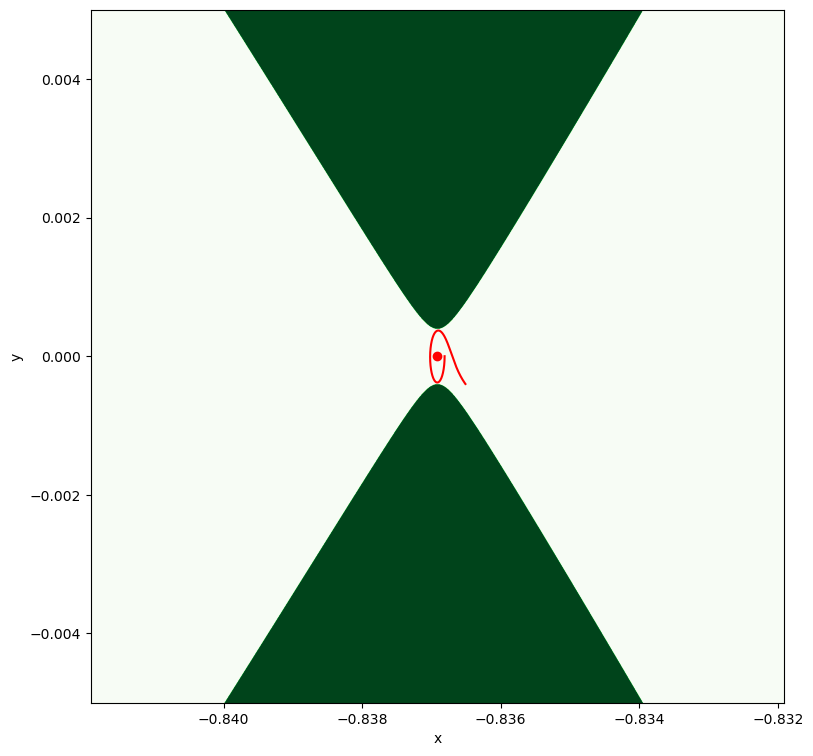

In [14]:
plt.figure(figsize=(9,9))

plt.subplot(1,1,1)
zoom=0.005
plt.plot(out0[5][:, 0], out0[5][:, 1],'r')

plt.xlabel("x")
plt.ylabel("y")

# Plot the zero velocity curve
xx = np.linspace(xL1-zoom,xL1+zoom,2000)
yy = np.linspace(-zoom,zoom,2000)
x_grid,y_grid = np.meshgrid(xx,yy)
im = plt.imshow( ((potential_function((x_grid,y_grid,np.zeros(np.shape(x_grid))),mu=mu)<=C_jacobi)).astype(int) , 
                extent=(x_grid.min(),x_grid.max(),y_grid.min(),y_grid.max()),origin="lower", cmap="Greens")

# Plot the lagrangian points and primaries
plt.scatter(mu, 0, c='k', s=300)
plt.scatter(mu-1, 0, c='k', s=100)
plt.scatter(xL1, 0, c='r')
plt.scatter(xL2, 0, c='r')
plt.scatter(xL3, 0, c='r')
plt.scatter(-0.5+mu, yL45, c='r')
plt.scatter(-0.5+mu, -yL45, c='r')


plt.xlim(xL1-zoom, xL1+zoom)
plt.ylim(-zoom, +zoom);

The orbit is good but does not close! Let us build an iteration that corrects $x_0,y_0, z_0, p_{x_0}, p_{y_0}, p_{z_0}, T$ as to close the orbit.

In [15]:
# Introduce a compiled function for the evaluation
# of the dynamics equations.
dyn_cf = hy.cfunc(f, vars=x)

def corrector(ta, x0):
    """
    Performs and logs a step of a corrector algorithm that takes a numerical integration from x0 -> T -> xf. The result
    is a new tentative x0 that should result in a closed orbit.
    """
    x0 = np.array(x0)
    mu = ta.pars[0]
    t_final = ta.time
    
    state_T = ta.state[:6]
    
    Phi = ta.state[6:].reshape((6,6))
    dynT = dyn_cf(state_T, pars=[mu]).reshape((-1,1))

    # We add as last state delta T
    A = np.concatenate((Phi-np.eye(6),dynT), axis=1)
    # We add the Poincare phasing condition as a last equation
    phasing_cond = np.insert(dynT,-1,0).reshape((1,-1))

    A = np.concatenate((A, phasing_cond))
    # We construct the r.h.s.
    b = (x0 - state_T).reshape(-1,1)
    print("error was:", np.linalg.norm(b))
    # need to add the zero corresponding to the phasing condition
    b = np.insert(b,-1,0)
    
    delta = np.linalg.inv(A)@b
    print("condition number is:", np.linalg.cond(A))
    
    x0_new = x0+delta[:6]
    t_final = t_final+delta[-1]

    # Reset the state
    ta.time = 0.
    ta.state[:] = x0_new.reshape((-1,)).tolist() + ic_var
    # Go ...
    ta.propagate_until(t_final)
    # New error is:
    b = (x0_new - ta.state[:6]).reshape(-1,1)
    print("new error is:", np.linalg.norm(b))
    return ta, x0_new.tolist()

Lets do some corrector iterations (not too many since as we get near to a periodic orbit, the condition number will explode)

In [16]:
ic_periodic = ic
for i in range(6):
    ta, ic_periodic = corrector(ta, ic_periodic)

error was: 0.0012972874386999722
condition number is: 16558416262.086914
new error is: 0.0011268499651408712
error was: 0.0011268499651408712
condition number is: 112029239.50776398
new error is: 0.005318388913864064
error was: 0.005318388913864064
condition number is: 97382195.71293469
new error is: 0.0008512521429497622
error was: 0.0008512521429497622
condition number is: 208596161.3646372
new error is: 6.615966149010238e-06
error was: 6.615966149010238e-06
condition number is: 33988164.714402355
new error is: 6.542953225678637e-08
error was: 6.542953225678637e-08
condition number is: 5547007599.431791
new error is: 1.771535461099794e-12


 .... et voila'!! As expected the iterations converge to a periodic orbit, while the matrix condition number increases to infinite as $\mathbf \Phi$ becomes a monodromy matrix.
 
Of course, we now visualize the orbit as to make sure its closed!

In [17]:
t_final = ta.time

# We compute  the IC Jacobi constant
C_jacobi = jacobi_constant(ic_periodic, mu)

# Reset the state
ta.time = 0.
ta.state[:] = ic_periodic + ic_var
ta.pars[0] = mu
# Time grid
t_grid = np.linspace(0, t_final, 2000)
# Go ...
out = ta.propagate_grid(t_grid)

mu:  0.01215057
Initial condition: [-8.3660628428208705e-01, 6.8716716228516570e-05, 0.0000000000000000e+00, -2.3615601659846791e-05, -8.3919863036055131e-01, 0.0000000000000000e+00]
Period: 2.6915996001661409e+00


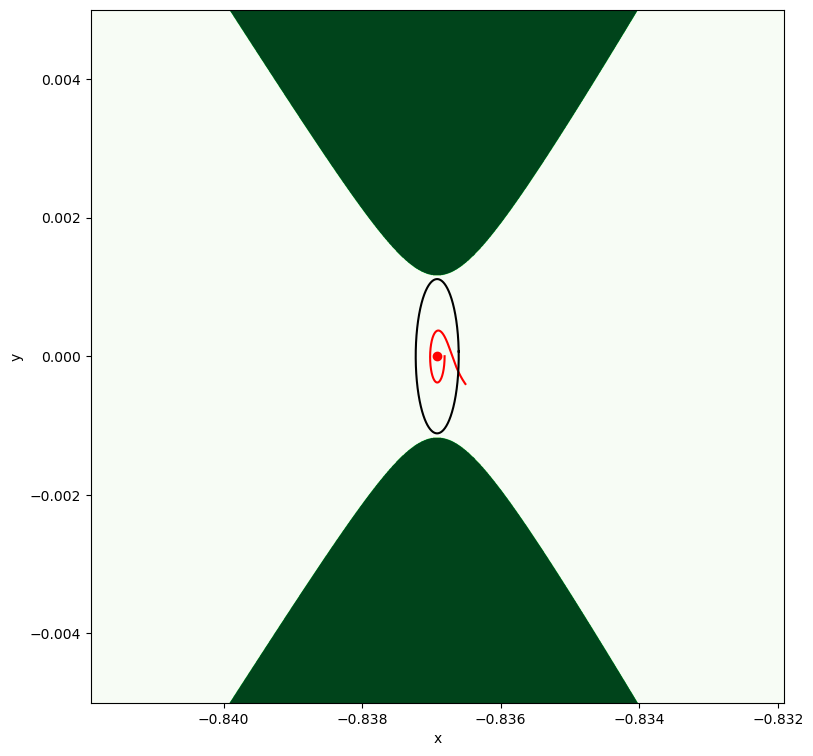

In [18]:
# We plot the initial condition (zoom in the Lagrangian point)
plt.figure(figsize=(9,9))

plt.subplot(1,1,1)
zoom=0.005
plt.plot(out0[5][:, 0], out0[5][:, 1],'r')
plt.plot(out[5][:, 0], out[5][:, 1],'k')

plt.xlabel("x")
plt.ylabel("y")

# Plot the zero velocity curve
xx = np.linspace(xL1-zoom,xL1+zoom,2000)
yy = np.linspace(-zoom,zoom,2000)
x_grid,y_grid = np.meshgrid(xx,yy)
im = plt.imshow( ((potential_function((x_grid,y_grid,np.zeros(np.shape(x_grid))),mu=mu)<=C_jacobi)).astype(int) , 
                extent=(x_grid.min(),x_grid.max(),y_grid.min(),y_grid.max()),origin="lower", cmap="Greens")

# Plot the lagrangian points and primaries
plt.scatter(mu, 0, c='k', s=300)
plt.scatter(mu-1, 0, c='k', s=100)
plt.scatter(xL1, 0, c='r')
plt.scatter(xL2, 0, c='r')
plt.scatter(xL3, 0, c='r')
plt.scatter(-0.5+mu, yL45, c='r')
plt.scatter(-0.5+mu, -yL45, c='r')


plt.xlim(xL1-zoom, xL1+zoom)
plt.ylim(-zoom, +zoom)

print("mu: ", ta.pars[0])
print(f"Initial condition: [{out[5][0,0]:.16e}, {out[5][0,1]:.16e}, {out[5][0,2]:.16e}, {out[5][0,3]:.16e}, {out[5][0,4]:.16e}, {out[5][0,5]:.16e}]")
print(f"Period: {t_final:.16e}")

## Continuing into a family of periodic orbits.

Since we now have initial conditions $\mathbf x_0$ that result in a periodic orbit, necessarily $\mathbf x_0 =\overline {\mathbf x}$, hence the periodicity condition becomes:

$$
\left(\mathbf \Phi -\mathbf I\right) \delta \mathbf x_0 + \mathbf f \delta T = \mathbf 0
$$

which is a system of 6 equations in seven unknowns. Futhermore, the monodromy matrix $\mathbf \Phi$ has now the eigenvalue 1, and thus $\left(\mathbf \Phi -\mathbf I\right)$ is not invertible! 

This corresponds, physically, to the fact that there are infinite possibilities to choose  $\delta \mathbf x_0$ so that $\mathbf x_0 + \delta \mathbf x_0$ results in a new periodic orbit having period $T + \delta T$.

We still make use of the Poincare' phasing condition so that the overall system we actually consider is:

$$
\left\{
\begin{array}{c}
\left(\mathbf \Phi -\mathbf I\right) \delta \mathbf x_0 + \mathbf f \delta T = \mathbf 0\\
\mathbf f \cdot \delta \mathbf x_0 =  0
\end{array}
\right.
$$

which we write as:

$$
\mathbf A_f \delta {\mathbf x_f} = \mathbf 0
$$

where we considered the full state $\delta {\mathbf x_f}$ including both $\delta \mathbf x_0$ and $\delta T$. The rank of the square 7x7 full matrix ${\mathbf A_f}$ is only 6, thus the linear system admits non trivial solutions. To find them we fix the value of one component of $\delta {\mathbf x_f}$ and thus obtain a new system with a reduced state and matrix:

$$
\mathbf A_r\delta {\mathbf x_r} = \mathbf b
$$

This is an overdetermined system of seven equations in six variables, but having only one only solution which we find as:

$$
\delta \mathbf x_r = (\mathbf A^T \mathbf A)^{-1}\mathbf A^T\mathbf b
$$

We have thus found a new initial guess to start with to find the next closed orbit in the family.

To start with, as validation and test of what we got so far, we get the monodromy matrix (from the last numerical integrated periodic orbit) ... 

In [19]:
Phi = ta.state[6:].reshape((6,6))

And compute its eigenvalues

In [20]:
eigv = np.linalg.eigvals(Phi)
print(eigv)

[2.67528714e+03+0.j         3.73791653e-04+0.j
 9.99999893e-01+0.j         1.00000011e+00+0.j
 9.84479860e-01+0.17549759j 9.84479860e-01-0.17549759j]


As expecetd we have two eigenvalues $\lambda_{3,4}$ equal to one, two real ones so that $\lambda_{1}\cdot \lambda_2=1$ (stable and unstable manifold) and two complex conjugated ones $\lambda_{5}\cdot \lambda_6=1$.

We write a simple function that takes as argument the result of some numerical integration over periodic conditions and creates new tentative initial guess continuing on the state parameter indexed by *idx*, (defaults to $x$).

Note that in the following function we assemble the full matrix $\mathbf A_f$ completed with the Poincare phase condition and having we consider as state ${\mathbf x_f} = [\delta x,\delta y,\delta z,\delta p_x,\delta p_y,\delta p_z,\delta T]$.  We then select a column, fix the corresponding value for the state variable, bring it to the right side and solve the resulting system which is overdetermined, but admits a unique solution since $\mathbf \Phi - \mathbf I$ is singular.

In [21]:
def predictor(ta, idx=0, variation=1e-4):
    Phi = ta.state[6:].reshape((6,6))
    state_T = ta.state[:6]
    state_T_dict = {"x":state_T[0], "y":state_T[1], "z":state_T[2], "px":state_T[3], "py":state_T[4], "pz":state_T[5]}
    # Compute the dynamics from its expressions
    dynT = dyn_cf(state_T, pars=[mu]).reshape((-1,1))
    # Computing the full A
    A = np.concatenate((Phi-np.eye(6), dynT.T))
    fullA = np.concatenate((A,np.insert(dynT,-1,0).reshape((-1,1))), axis=1)
    # Computing the A resulting from fixing the continuation parameter to a selected state.
    A = fullA[:,list(set(range(7))-set([idx]))]
    b = - fullA[:,[idx]] * variation
    # We solve.
    dx = np.linalg.inv((A.T@A)) @ (A.T@b)
    # Assembling back the full state (x,y,z,px,py,pz,T)
    dx = np.insert(dx,idx,variation)
    return dx

We can now use the function to create a new initial guess:

In [22]:
dx = predictor(ta)
ic_continued_guess = [a+b for a,b in zip(ic_periodic, dx[:6].tolist())]
new_T = ta.time + dx[-1]

Let us visualize as usual the resulting orbit .... (code is repeated for convenience, but its identical to above cells)

In [23]:
C_jacobi = jacobi_constant(ic_continued_guess, mu)

# Reset the state
ta.time = 0.
ta.state[:] = ic_continued_guess + ic_var
ta.pars[0] = mu
# Time grid
t_grid = np.linspace(0, new_T, 2000)
# Go ...
out2 = ta.propagate_grid(t_grid)

(-0.005, 0.005)

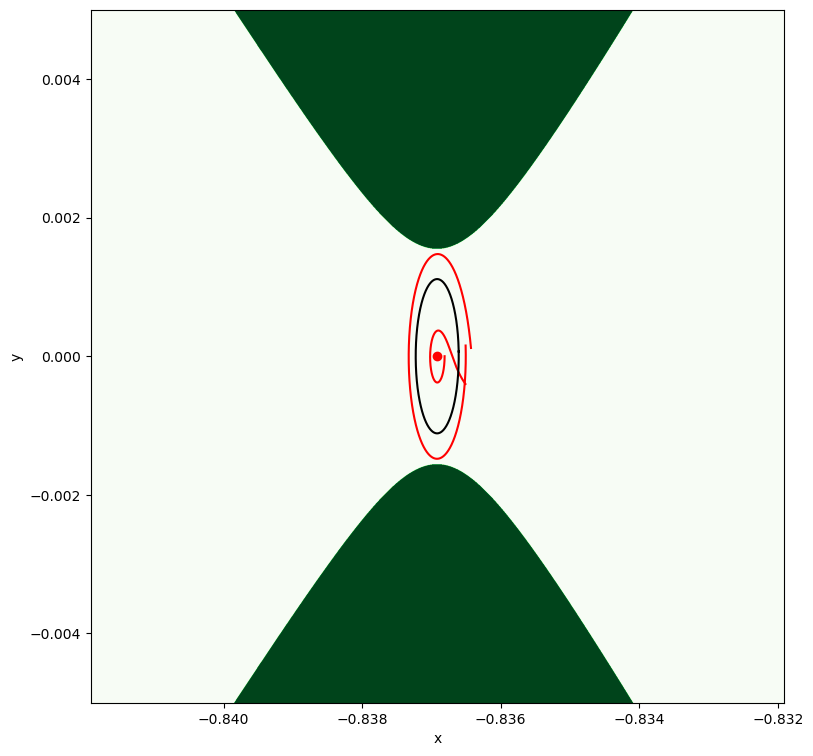

In [24]:
# We plot the initial condition (zoom in the Lagrangian point)
plt.figure(figsize=(9,9))

plt.subplot(1,1,1)
zoom=0.005
plt.plot(out0[5][:, 0], out0[5][:, 1], 'r')
plt.plot(out[5][:, 0], out[5][:, 1],'k')
plt.plot(out2[5][:, 0], out2[5][:, 1],'r')

plt.xlabel("x")
plt.ylabel("y")

# Plot the zero velocity curve
xx = np.linspace(xL1-zoom,xL1+zoom,2000)
yy = np.linspace(-zoom,zoom,2000)
x_grid,y_grid = np.meshgrid(xx,yy)
im = plt.imshow( ((potential_function((x_grid,y_grid,np.zeros(np.shape(x_grid))),mu=mu)<=C_jacobi)).astype(int) , 
                extent=(x_grid.min(),x_grid.max(),y_grid.min(),y_grid.max()),origin="lower", cmap="Greens")

# Plot the lagrangian points and primaries
plt.scatter(mu, 0, c='k', s=300)
plt.scatter(mu-1, 0, c='k', s=100)
plt.scatter(xL1, 0, c='r')
plt.scatter(xL2, 0, c='r')
plt.scatter(xL3, 0, c='r')
plt.scatter(-0.5+mu, yL45, c='r')
plt.scatter(-0.5+mu, -yL45, c='r')


plt.xlim(xL1-zoom, xL1+zoom)
plt.ylim(-zoom, +zoom)

It's nearly closed, but not that well .... it will need a correction ... but we can call the same iterations we made previously when we closed the first initial guess, remember?

In [25]:
ic_continued = ic_continued_guess
for i in range(3):
    ta, ic_continued = corrector(ta, ic_continued)

error was: 0.00027713982303279586
condition number is: 15773618.561420336
new error is: 9.470894213691114e-07
error was: 9.470894213691114e-07
condition number is: 78690773437.61931
new error is: 6.077500558656773e-09
error was: 6.077500558656773e-09
condition number is: 859354545799.8098
new error is: 9.972303343724588e-14


And we visualize all the initial guesses and closed orbit found so far:

In [26]:
t_final = ta.time

# We compute  the IC Jacobi constant
C_jacobi = jacobi_constant(ic_continued, mu)

# Reset the state
ta.time = 0.
ta.state[:] = ic_continued + ic_var
ta.pars[0] = mu
# Time grid
t_grid = np.linspace(0, t_final, 2000)
# Go ...
out3 = ta.propagate_grid(t_grid)

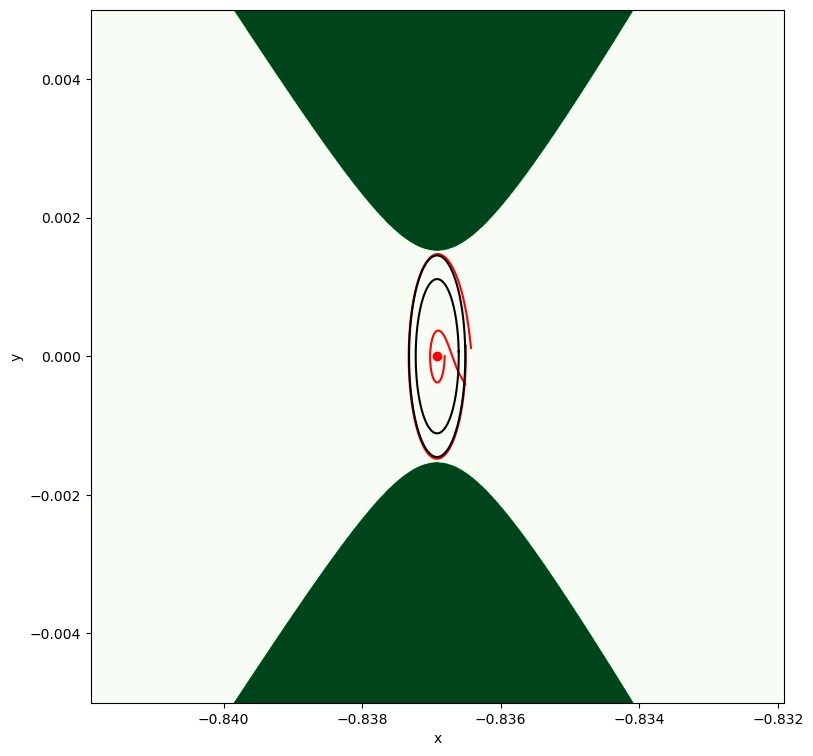

In [27]:
# We plot the initial condition (zoom in the Lagrangian point)
plt.figure(figsize=(9,9))

plt.subplot(1,1,1)
zoom=0.005
plt.plot(out0[5][:, 0], out0[5][:, 1],'r')
plt.plot(out[5][:, 0], out[5][:, 1],'k')
plt.plot(out2[5][:, 0], out2[5][:, 1],'r')
plt.plot(out3[5][:, 0], out3[5][:, 1],'k')

plt.xlabel("x")
plt.ylabel("y")

# Plot the zero velocity curve
xx = np.linspace(xL1-zoom,xL1+zoom,2000)
yy = np.linspace(-zoom,zoom,2000)
x_grid,y_grid = np.meshgrid(xx,yy)
im = plt.imshow( ((potential_function((x_grid,y_grid,np.zeros(np.shape(x_grid))),mu=mu)<=C_jacobi)).astype(int) , 
                extent=(x_grid.min(),x_grid.max(),y_grid.min(),y_grid.max()),origin="lower", cmap="Greens")

# Plot the lagrangian points and primaries
plt.scatter(mu, 0, c='k', s=300)
plt.scatter(mu-1, 0, c='k', s=100)
plt.scatter(xL1, 0, c='r')
plt.scatter(xL2, 0, c='r')
plt.scatter(xL3, 0, c='r')
plt.scatter(-0.5+mu, yL45, c='r')
plt.scatter(-0.5+mu, -yL45, c='r')


plt.xlim(xL1-zoom, xL1+zoom)
plt.ylim(-zoom, +zoom);

Found it! In order to do this in a loop, though, we will need to do better as eventually this will fail as the continuation parameter
here used, i.e., the period $T$, will create issues as it is not monotonically increasng with the orbit size.

The solution requires a bit more math, and it is given by the definition and use of a [pseudo arc-length](<./Pseudo arc-length continuation in the CR3BP.ipynb>).